In [28]:
from uncertainties import ufloat
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.constants as C

<h2> Primera parte: Kurie Plot </h2>

<h3> Calculamos el eje x </h3>

Hacemos los cálculos de la calibración

In [29]:
e1 = 661.7 #keV
e2 = 356.0 #keV

c1 = 715.38
c2 = 401.04

a = (e2-e1)/(c2-c1)
b = (c2*e1-c1*e2)/(c2-c1)

In [30]:
canales = np.arange(2048)
T = a*canales+b
print("T =",T)

me_kev = C.c**2*C.m_e/C.e/1000 #keV

beta = np.sqrt(2*T*me_kev+(T**2))/(me_kev+T)
beta[np.where(T < 0)] = 0
print("beta =", beta)

T = [ -34.0169498   -33.04443596  -32.07192212 ... 1954.77384997 1955.74636381
 1956.71887765]
beta = [0.         0.         0.         ... 0.9782908  0.97830811 0.97832539]


<ipython-input-30-6d60439d1d9a>:7: RuntimeWarning: invalid value encountered in sqrt
  beta = np.sqrt(2*T*me_kev+(T**2))/(me_kev+T)


In [31]:
alpha = 1/137

eta = 40*alpha/beta
eta[beta == 0] = 0

F = 2*C.pi*eta/(1-np.exp(-2*C.pi*eta))
F[eta == 0] = 0
F = np.reshape(F, (2048,1))

<ipython-input-31-87208659df17>:3: RuntimeWarning: divide by zero encountered in true_divide
  eta = 40*alpha/beta
<ipython-input-31-87208659df17>:6: RuntimeWarning: invalid value encountered in true_divide
  F = 2*C.pi*eta/(1-np.exp(-2*C.pi*eta))


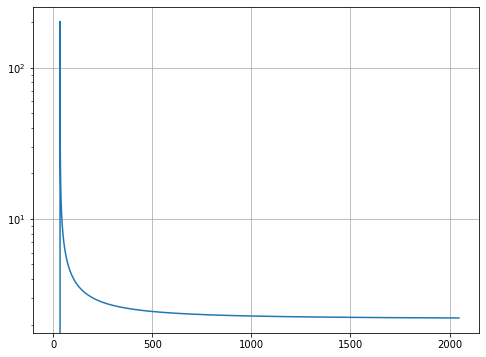

In [51]:
plt.semilogy(F)
plt.grid()

<h3> Calculamos el eje y </h3>

Text(0, 0.5, 'N(c)')

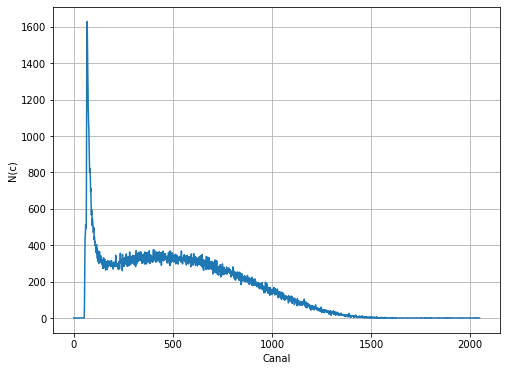

In [53]:
data = pd.read_csv("SR-90.txt").to_numpy()
plt.plot(data)
plt.grid()
plt.xlabel("Canal")
plt.ylabel("N(c)")

In [34]:
Nc = data
err_Nc = np.sqrt(Nc)

In [35]:
cp = np.array(np.sqrt(T*(T+2*me_kev)))
cp = np.reshape(cp, (2048,1))

<ipython-input-35-cab8044fc879>:1: RuntimeWarning: invalid value encountered in sqrt
  cp = np.array(np.sqrt(T*(T+2*me_kev)))


In [36]:
Nc_err = np.array([ufloat(Nx, errx) for Nx, errx in zip(Nc, err_Nc)])
Nc_err = np.reshape(Nc_err, (2048,1))

NT_err = Nc_err / a

Ncp_err = []
for i in range(2048):
    if NT_err[i,0].nominal_value == 0:
        app = ufloat(0,0)
    else:
        N = NT_err[i,0]
        app = N / ((2*me_kev+2*N)/(2*(N*(2*me_kev+N))**0.5))

    Ncp_err.append(app)

Ncp_err = np.reshape(Ncp_err, (2048,1))

y_err = (Ncp_err/(cp**2*F))**0.5

y_final = [x.nominal_value for x in y_err[:,0]]
err_final = [x.std_dev for x in y_err[:,0]]


In [37]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7

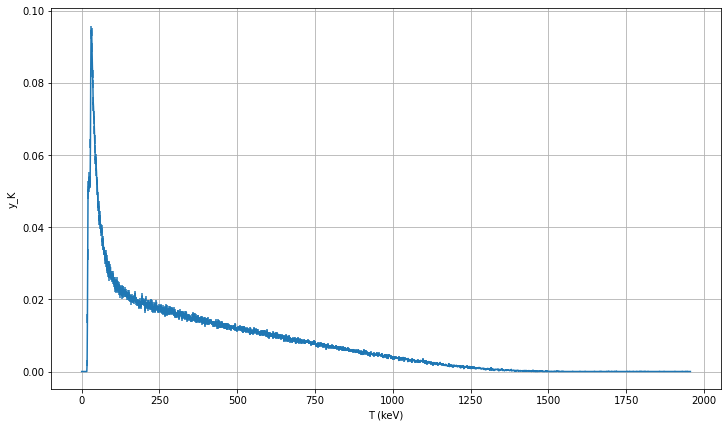

In [38]:

plt.errorbar(x=T, y=y_final, yerr=err_final)
plt.grid()
plt.xlabel("T (keV)")
plt.ylabel("y_K")
plt.show()

Guardamos los datos en un fichero para hacer el ajuste con Gnuplot

In [39]:
dataset = pd.DataFrame({"Energy(keV)": T,
                        "y": y_final,
                        "err_y":err_final})
dataset = dataset.fillna(0)
print(dataset)
pd.DataFrame.to_csv(dataset, "datos_finales.txt")

      Energy(keV)    y  err_y
0      -34.016950  0.0    0.0
1      -33.044436  0.0    0.0
2      -32.071922  0.0    0.0
3      -31.099408  0.0    0.0
4      -30.126894  0.0    0.0
...           ...  ...    ...
2043  1952.828822  0.0    0.0
2044  1953.801336  0.0    0.0
2045  1954.773850  0.0    0.0
2046  1955.746364  0.0    0.0
2047  1956.718878  0.0    0.0

[2048 rows x 3 columns]


<h3>Tras el ajuste de la recta con gnuplot</h3>

In [40]:
m = ufloat(-1.73419e-05, 7.332e-08)
n = ufloat(0.0208886, 5.443e-05)

E_corte = -n/m

print("E_corte =", E_corte,"keV")

E_corte = 1205+/-6 keV


<h1> Segunda parte: medida del grosor de la lamina de aluminio </h1>

Pasa de 2483 keV a 1205 keV

$$ \Delta x = \int_{E_1}^{E_2}\frac{dE}{|-\frac{dE}{dx}|}$$

In [41]:
df = pd.read_csv("stopping_power.txt", sep=",").to_numpy()
E = df[:,0] * 1000 #keV
dEdx = df[:,1] * 2.6984 * 1000 #keV/cm
dE = np.array([E[i] - E[i-1] for i in range(1,len(E))])

E2 = 2283
E1 = E_corte.nominal_value

In [42]:
mask_inf = np.logical_and(E>E1, E<E2)
print(E[mask_inf])

mask_sup = [32,33,34,35,36,37]
print(E[mask_sup])

[1250. 1500. 1750. 2000.]
[1000. 1250. 1500. 1750. 2000. 2500.]


In [43]:
f = dE[mask_inf[:-1]] / dEdx[mask_inf]
Dx_inf = np.trapz(f)
print(Dx_inf)

f = dE[list(np.array(mask_sup)-1)] / dEdx[mask_sup]
Dx_sup = np.trapz(f)
print(Dx_sup)

0.21598661990471957
0.3194826284526063


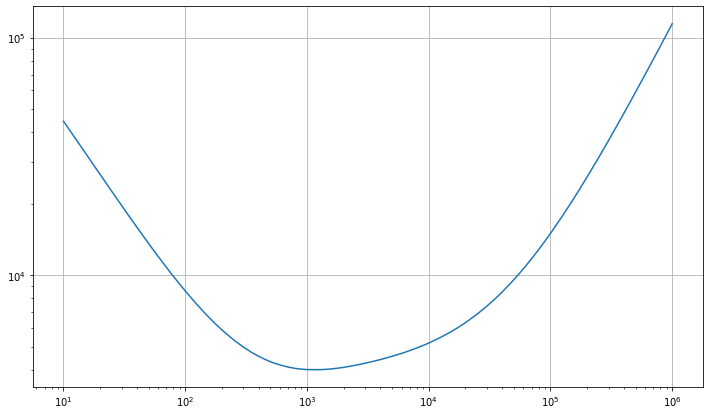

In [44]:
plt.loglog(E,dEdx)
plt.grid()

In [45]:
def interpolar(x, p1, p2):
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    return -((x1-x)*y2+(x-x2)*y1)/(x2-x1)

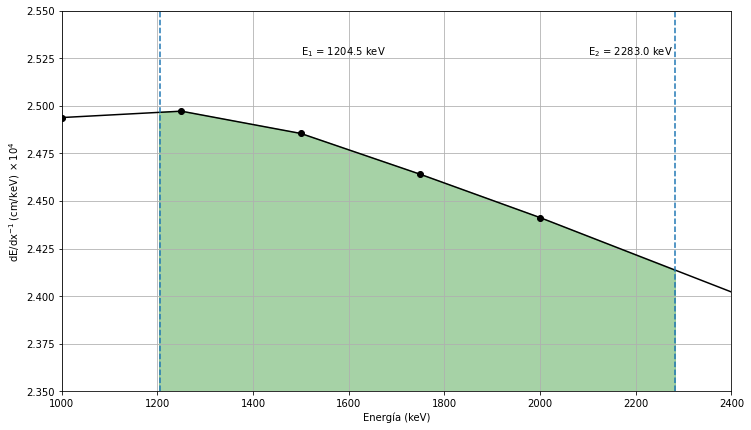

In [46]:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

imin = 32
imax = 38

plt.plot(E[imin-1:imax+1], 1e4/np.array(dEdx[imin-1:imax+1]), marker="o", color="black")

xfill = [E1, E[33], E[34], E[35], E[36], E2]

y1 = interpolar(E1, (E[32], dEdx[32]), (E[33], dEdx[33]))
y2 = interpolar(E2, (E[36], dEdx[36]), (E[37], dEdx[37]))

yfill = 1e4* 1/np.array([y1, dEdx[33], dEdx[34], dEdx[35], dEdx[36], y2])
plt.fill_between(xfill, yfill, color="green", alpha=0.35)

plt.ylim([1e4*0.000235, 1e4*0.000255])
plt.xlim([1000, 2400])

plt.axvline(x=E2, linestyle="--")
plt.axvline(x=E1, linestyle="--")

plt.xlabel("Energía (keV)")
plt.ylabel(r"$dE/dx^{-1}\; (cm/keV) \;\times 10^{4}$")

plt.text(1500, 2.527, f"$E_1$ = {E_corte.nominal_value:.1f} keV")
plt.text(2100, 2.527, f"$E_2$ = {E2:.1f} keV")

plt.grid()
plt.show()

Hacemos la integración numérica con numpy.trapz()

In [55]:
Delta_x = np.trapz(1e-4*yfill, xfill)
print("Delta_x =", Delta_x, "cm")

Delta_x = 0.2655214859018191 cm
